In [1]:
!pip install mediapipe

In [2]:
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import mediapipe as mp
import cv2
import os

from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow

import dlib
from skimage import io
import matplotlib.pyplot as plt
from numpy import asarray


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
imgPath=[]
resize= 1
frame_count_real = []
frame_count_fake = []


# Function to extract frames
def FrameCapture(path,globalCount,type_dataset,label):
    frame_count=[]
    imgPath = []
    temp = 0
    v_cap = cv2.VideoCapture(path)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Pick 'n_frames' evenly spaced frames to sample
    sample = np.linspace(0, v_len - 1, n_frames).astype(int) #Index in sample array are the frames which will be extracted.

    # Loop through frames
    
    frames = []
    for j in range(v_len):
        success = v_cap.grab()
        if j in sample:
            # Load frame
            success, frame = v_cap.read()
            if not success:
                
                continue
           
            frame = Image.fromarray(frame)
            
            # Resize frame to desired size
            if resize is not None:
                frame = frame.resize([int(d * resize) for d in frame.size])
                frame = np.asarray(frame)
            frames.append(frame)
    
    # Used as counter variable
  
    # checks whether frames were extracted
    count = globalCount
    currentCount = 0
    success = 1
  
    while success and currentCount<min(n_frames,len(frames)):
  

        cv2.imwrite("All_Images/" + str(type_dataset) + "_"+ str(label) + "_frame%d.jpg" % (count//n_frames),frames[int(currentCount)])

        imgPath.append("All_Images/" + str(type_dataset) + "_"+ str(label) + "_frame%d.jpg"%(count//n_frames))
  
        count += n_frames
        currentCount += 1
      
    if(type_dataset!="Train"):
      frame_count.append(currentCount)

    return imgPath,count,frame_count



In [5]:
import os


n_frames = 32
resize= 1

def captureFrame(type_dataset,label):
  imgPath = []
  frame_count = []
  count = 0
  video_label=[]
  temp = True
  if temp:
    for file in os.listdir("/content/drive/MyDrive/Deepfake_Mix/"+str(type_dataset)+"/"+str(label)):
        path=os.path.join("/content/drive/MyDrive/Deepfake_Mix/"+str(type_dataset)+"/"+str(label), file)
        temp , count ,x= FrameCapture(path,count,type_dataset,label)
        imgPath = imgPath +  temp
        if (type_dataset != 'Train'):
          frame_count.append(x[0])
          if label=='Fake':
            video_label.append(0)
          else:
            video_label.append(1)
  else:
    for file in os.listdir("/content/drive/MyDrive/Deepfake_Mix_Half/"+str(type_dataset)+"/"+str(label)):
        path=os.path.join("/content/drive/MyDrive/Deepfake_Mix_Half/"+str(type_dataset)+"/"+str(label), file)
        temp , count ,x= FrameCapture(path,count,type_dataset,label)
        imgPath = imgPath +  temp
        if (type_dataset != 'Train'):
          frame_count.append(x[0])
          if label=='Fake':
            video_label.append(0)
          else:
            video_label.append(1)
  return imgPath,frame_count,video_label

In [6]:
imgPath_train_fake,  frame_count_train_fake, _= captureFrame("Train","Fake")
imgPath_train_real,  frame_count_train_real, _= captureFrame("Train","Real")
imgPath_val_fake,  frame_count_val_fake, video_label_val_fake= captureFrame("Val","Fake")
imgPath_val_real,  frame_count_val_real, video_label_val_real= captureFrame("Val","Real")
imgPath_test_fake,  frame_count_test_fake, video_label_test_fake= captureFrame("Test","Fake")
imgPath_test_real,  frame_count_test_real, video_label_test_real= captureFrame("Test","Real")

In [9]:
print(imgPath_train_fake)
print(imgPath_train_real)
print(imgPath_val_fake)
print(imgPath_val_real)
print(imgPath_test_fake)
print(imgPath_test_real)

['All_Images/Train_Fake_frame0.jpg', 'All_Images/Train_Fake_frame1.jpg', 'All_Images/Train_Fake_frame2.jpg', 'All_Images/Train_Fake_frame3.jpg', 'All_Images/Train_Fake_frame4.jpg', 'All_Images/Train_Fake_frame5.jpg', 'All_Images/Train_Fake_frame6.jpg', 'All_Images/Train_Fake_frame7.jpg', 'All_Images/Train_Fake_frame8.jpg', 'All_Images/Train_Fake_frame9.jpg', 'All_Images/Train_Fake_frame10.jpg', 'All_Images/Train_Fake_frame11.jpg', 'All_Images/Train_Fake_frame12.jpg', 'All_Images/Train_Fake_frame13.jpg', 'All_Images/Train_Fake_frame14.jpg', 'All_Images/Train_Fake_frame15.jpg', 'All_Images/Train_Fake_frame16.jpg', 'All_Images/Train_Fake_frame17.jpg', 'All_Images/Train_Fake_frame18.jpg', 'All_Images/Train_Fake_frame19.jpg', 'All_Images/Train_Fake_frame20.jpg', 'All_Images/Train_Fake_frame21.jpg', 'All_Images/Train_Fake_frame22.jpg', 'All_Images/Train_Fake_frame23.jpg', 'All_Images/Train_Fake_frame24.jpg', 'All_Images/Train_Fake_frame25.jpg', 'All_Images/Train_Fake_frame26.jpg', 'All_Image

# MediaPipe

In [10]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

mp_face_detection

<module 'mediapipe.python.solutions.face_detection' from '/usr/local/lib/python3.7/dist-packages/mediapipe/python/solutions/face_detection.py'>

In [11]:
def faceDetect_MediaPipe(type_dataset,label,imgPath,frame):
  # For static images:
  count=0
  processedImagePath_mediapipe=[]

  j = 0
  k = 0


  with mp_face_detection.FaceDetection(
      min_detection_confidence=0.5) as face_detection:

    for i in range(len(imgPath)):

      if(type_dataset != "Train"):
         if(j > frame[k]):
           k += 1
           j = 0

      file = imgPath[i]

      image = PIL.Image.open(file)
      d1, d2 = image.size
      
      image = cv2.imread(file)
      

      # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
      results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      # Draw face detections of each face.
      if not results.detections:
        if(type_dataset != "Train"):
            frame[k] -=1
        continue
      annotated_image = image.copy()
      
      for detection in results.detections:
        
        
        
        x,y,w,h = detection.location_data.relative_bounding_box.xmin,detection.location_data.relative_bounding_box.ymin,detection.location_data.relative_bounding_box.width,detection.location_data.relative_bounding_box.height
        x,y,w,h = int(x*d1),int(y*d2),int(w*d1),int(h*d2)
        crop_img = annotated_image[y:y+h, x:x+w]
        resize_face = cv2.resize(crop_img,(64, 64), interpolation=cv2.INTER_CUBIC)
        

        info = mp_face_detection.FaceDetection()
        x = info.process(image=image)
        

        
        cv2.imwrite("MediaPipe" + "_" + str(type_dataset) + "_" + str(label) + "/mediapipe%d.jpg" % count,resize_face)
        
        processedImagePath_mediapipe.append("MediaPipe" + "_" + str(type_dataset) + "_" + str(label) + "/mediapipe%d.jpg"%count)
        count+=1

        j+=1

        

  return processedImagePath_mediapipe,frame


In [12]:
processedImagePath_Train_Fake_mediapipe , _ = faceDetect_MediaPipe("Train","Fake",imgPath_train_fake,[])

In [13]:
processedImagePath_Train_Real_mediapipe , _ = faceDetect_MediaPipe("Train","Real",imgPath_train_real,[])

In [14]:
print(processedImagePath_Train_Fake_mediapipe)
print(processedImagePath_Train_Real_mediapipe)

['MediaPipe_Train_Fake/mediapipe0.jpg', 'MediaPipe_Train_Fake/mediapipe1.jpg', 'MediaPipe_Train_Fake/mediapipe2.jpg', 'MediaPipe_Train_Fake/mediapipe3.jpg', 'MediaPipe_Train_Fake/mediapipe4.jpg', 'MediaPipe_Train_Fake/mediapipe5.jpg', 'MediaPipe_Train_Fake/mediapipe6.jpg', 'MediaPipe_Train_Fake/mediapipe7.jpg', 'MediaPipe_Train_Fake/mediapipe8.jpg', 'MediaPipe_Train_Fake/mediapipe9.jpg', 'MediaPipe_Train_Fake/mediapipe10.jpg', 'MediaPipe_Train_Fake/mediapipe11.jpg', 'MediaPipe_Train_Fake/mediapipe12.jpg', 'MediaPipe_Train_Fake/mediapipe13.jpg', 'MediaPipe_Train_Fake/mediapipe14.jpg', 'MediaPipe_Train_Fake/mediapipe15.jpg', 'MediaPipe_Train_Fake/mediapipe16.jpg', 'MediaPipe_Train_Fake/mediapipe17.jpg', 'MediaPipe_Train_Fake/mediapipe18.jpg', 'MediaPipe_Train_Fake/mediapipe19.jpg', 'MediaPipe_Train_Fake/mediapipe20.jpg', 'MediaPipe_Train_Fake/mediapipe21.jpg', 'MediaPipe_Train_Fake/mediapipe22.jpg', 'MediaPipe_Train_Fake/mediapipe23.jpg', 'MediaPipe_Train_Fake/mediapipe24.jpg', 'MediaPip

In [15]:
processedImagePath_Test_Fake_mediapipe , frame_count_test_fake = faceDetect_MediaPipe("Test","Fake",imgPath_test_fake,frame_count_test_fake)

In [16]:
processedImagePath_Test_Real_mediapipe , frame_count_test_real = faceDetect_MediaPipe("Test","Real",imgPath_test_real , frame_count_test_real)

In [17]:
print(processedImagePath_Test_Fake_mediapipe)
print(processedImagePath_Test_Real_mediapipe)

['MediaPipe_Test_Fake/mediapipe0.jpg', 'MediaPipe_Test_Fake/mediapipe1.jpg', 'MediaPipe_Test_Fake/mediapipe2.jpg', 'MediaPipe_Test_Fake/mediapipe3.jpg', 'MediaPipe_Test_Fake/mediapipe4.jpg', 'MediaPipe_Test_Fake/mediapipe5.jpg', 'MediaPipe_Test_Fake/mediapipe6.jpg', 'MediaPipe_Test_Fake/mediapipe7.jpg', 'MediaPipe_Test_Fake/mediapipe8.jpg', 'MediaPipe_Test_Fake/mediapipe9.jpg', 'MediaPipe_Test_Fake/mediapipe10.jpg', 'MediaPipe_Test_Fake/mediapipe11.jpg', 'MediaPipe_Test_Fake/mediapipe12.jpg', 'MediaPipe_Test_Fake/mediapipe13.jpg', 'MediaPipe_Test_Fake/mediapipe14.jpg', 'MediaPipe_Test_Fake/mediapipe15.jpg', 'MediaPipe_Test_Fake/mediapipe16.jpg', 'MediaPipe_Test_Fake/mediapipe17.jpg', 'MediaPipe_Test_Fake/mediapipe18.jpg', 'MediaPipe_Test_Fake/mediapipe19.jpg', 'MediaPipe_Test_Fake/mediapipe20.jpg', 'MediaPipe_Test_Fake/mediapipe21.jpg', 'MediaPipe_Test_Fake/mediapipe22.jpg', 'MediaPipe_Test_Fake/mediapipe23.jpg', 'MediaPipe_Test_Fake/mediapipe24.jpg', 'MediaPipe_Test_Fake/mediapipe25.j

In [18]:
print(len(processedImagePath_Test_Fake_mediapipe))
print(len(processedImagePath_Test_Real_mediapipe))
print(sum(frame_count_test_fake),sum(frame_count_test_real))

622
739
622 728


In [19]:
processedImagePath_Val_Fake_mediapipe , frame_count_val_fake = faceDetect_MediaPipe("Val","Fake",imgPath_val_fake,frame_count_val_fake)

In [20]:
processedImagePath_Val_Real_mediapipe , frame_count_val_real = faceDetect_MediaPipe("Val","Real",imgPath_val_real,frame_count_val_real)

#Data Augmentation

In [21]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from skimage.util import random_noise
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import argparse

In [22]:
import numpy as np
import os
import cv2

def noisy(noise_typ,image):
  if noise_typ == "gauss":
    mean = 0
    var = 100
    sigma = var ** 0.5
    row, col, _ = image.shape
    gaussian = np.random.normal(mean, sigma, (row, col)) 

    noisy = np.zeros(image.shape, np.float32)

    if len(image.shape) == 2:
        noisy = image + gaussian
    else:
        noisy[:, :, 0] = image[:, :, 0] + gaussian
        noisy[:, :, 1] = image[:, :, 1] + gaussian
        noisy[:, :, 2] = image[:, :, 2] + gaussian

    cv2.normalize(noisy, noisy, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy = noisy.astype(np.uint8)
    return noisy
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.05
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out

  
  
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)
    noisy = image + image * gauss
    return noisy


In [23]:
def create_noisy_img(face_detector,face_detector_arr,type_dataset,label):
    arr=[]
    for i in range(len(face_detector_arr)):
        img=cv2.imread(face_detector_arr[i])
        if face_detector!="MediaPipe":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        noisy_img = noisy("gauss", img)
        noisy_img = cv2.resize(noisy_img, (64, 64))
        
        cv2.imwrite("/content/MediaPipe_"+type_dataset+"_"+label+"_Noise/mediapipe_noise%d.jpg" % i,noisy_img)
        arr.append("/content/MediaPipe_"+type_dataset+"_"+label+"_Noise/mediapipe_noise%d.jpg"%i)
    return arr


In [24]:
processedImagePath_Train_Fake_mediapipe_noise=create_noisy_img("MediaPipe",processedImagePath_Train_Fake_mediapipe,"Train","Fake")

In [25]:
processedImagePath_Train_Real_mediapipe_noise=create_noisy_img("MediaPipe",processedImagePath_Train_Real_mediapipe,"Train","Real")

# Training

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from skimage.color import rgb2grey
from skimage.feature import hog

def create_features(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features=[]
    for i in gray:
      for j in i:
        features.append(j)
    
    return features


In [27]:
def createFeatureDatabase(real_list, fake_list):
  train=[]
  label = []

  

  for i in range(len(fake_list)):
    img = cv2.imread(fake_list[i])
    tmp_features = create_features(img)
    train.append(tmp_features)
    label.append(0)

  for i in range(len(real_list)):
    img = cv2.imread(real_list[i])
    tmp_features = create_features(img)
    train.append(tmp_features)
    label.append(1)

  
  return train,label

In [28]:
train_data,label_data = createFeatureDatabase(processedImagePath_Train_Real_mediapipe,processedImagePath_Train_Fake_mediapipe)

In [29]:
len(train_data)

2760

In [30]:
test_data, test_label = createFeatureDatabase(processedImagePath_Test_Real_mediapipe,processedImagePath_Test_Fake_mediapipe)

In [31]:
train_data_noise,label_data_noise = createFeatureDatabase(processedImagePath_Train_Real_mediapipe_noise,processedImagePath_Train_Fake_mediapipe_noise)

In [32]:
len(label_data_noise)

2760

In [33]:
len(label_data)

2760

## Standard Scaler

In [34]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

scaler.fit(train_data)  
train_data_ss = scaler.transform(train_data)  

test_data_ss = scaler.transform(test_data)

In [35]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

scaler.fit(train_data_noise)  
train_data_ss_noise = scaler.transform(train_data_noise)  

test_data_ss = scaler.transform(test_data)

## LDA

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda_train_data = lda.fit_transform(train_data_ss, label_data)


In [37]:
lda_test_data=lda.transform(test_data_ss)

In [38]:
lda.explained_variance_ratio_

array([1.])

In [39]:
lda_train_data

array([[-7.17543391],
       [-2.43903363],
       [-2.64694522],
       ...,
       [ 5.65648646],
       [ 2.74928279],
       [ 3.64409997]])

In [40]:
len(lda_train_data[0])

1

## PCA

In [41]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
pca_train_data=pca.fit_transform(train_data_ss)

In [42]:
pca_train_data

array([[-2.85712500e+01,  6.08879158e+00, -1.34110732e+01, ...,
        -1.85820998e-01, -4.81187362e-02, -4.20005577e-01],
       [-2.92900834e+01,  5.80390581e+00, -1.44870959e+01, ...,
        -1.60322395e-01,  2.09212082e-02, -4.39091636e-01],
       [-2.85311344e+01,  6.24373040e+00, -1.35127501e+01, ...,
        -2.21808599e-01, -3.22938420e-02, -4.25875695e-01],
       ...,
       [ 3.93087149e+01,  2.08254635e+01, -1.41474430e+01, ...,
        -2.97802215e-02, -1.06744272e-01, -3.03636350e-01],
       [ 3.11235077e+01,  1.92215069e+01, -1.90573908e+01, ...,
         2.12665789e-02, -4.06227533e-02,  1.97146378e-01],
       [ 2.43395176e+01,  1.24218589e+01, -1.94691898e+01, ...,
         1.33954273e-01, -1.91022600e-01,  2.04453103e-02]])

In [43]:
len(pca_train_data)

2760

In [44]:
pca_train_data_noise=pca.transform(train_data_ss_noise)

In [45]:
len(pca_train_data_noise)

2760

In [46]:
pca_test_data=pca.transform(test_data_ss)

In [47]:
pca.explained_variance_ratio_

array([3.01471361e-01, 1.05800653e-01, 6.51910450e-02, 4.38693891e-02,
       3.79067757e-02, 3.12366208e-02, 2.41537553e-02, 1.79361419e-02,
       1.74475074e-02, 1.43210757e-02, 1.31733307e-02, 1.17921431e-02,
       1.06376771e-02, 9.08863930e-03, 8.88701794e-03, 8.14293005e-03,
       7.53917017e-03, 7.26951963e-03, 6.69652764e-03, 6.45952342e-03,
       5.85814233e-03, 5.30236771e-03, 5.00531441e-03, 4.85256656e-03,
       4.73927461e-03, 4.65739948e-03, 4.38454566e-03, 4.08749531e-03,
       3.83479038e-03, 3.75866268e-03, 3.43477825e-03, 3.36799651e-03,
       3.31962240e-03, 3.15791917e-03, 3.08249511e-03, 2.94125142e-03,
       2.89333672e-03, 2.72334062e-03, 2.61439243e-03, 2.58764402e-03,
       2.51310283e-03, 2.45284066e-03, 2.30220000e-03, 2.25079258e-03,
       2.23990436e-03, 2.20629793e-03, 2.13642807e-03, 2.12568205e-03,
       2.06370919e-03, 1.97409322e-03, 1.90592007e-03, 1.83224687e-03,
       1.82543622e-03, 1.74827999e-03, 1.70185847e-03, 1.63766642e-03,
      

In [48]:
pca_train_data_noise

array([[ 16.0169503 ,  12.25230184, -16.77099523, ...,  -0.17917012,
         -0.41494209,  -0.45843038],
       [ 20.15215737,  13.22459757, -17.77876852, ...,  -0.6345623 ,
         -0.1371647 ,  -0.41427949],
       [ 11.76765911,  12.27013919, -16.96987617, ...,  -0.55343327,
          0.04578826,  -0.65946975],
       ...,
       [  5.22530158,  15.75007914, -11.77815691, ...,   0.08417023,
          0.32021063,  -0.36418891],
       [  1.97843995,  14.64341609, -17.08523607, ...,   0.53400712,
          0.07663096,   0.41212463],
       [  0.71902381,   8.43452356, -17.52488375, ...,   0.07402466,
         -0.44516953,   0.4599015 ]])

# DeepFake Result

In [49]:
def predictDeepFakeResult(predicted_test,frame_count_test):
  k=0
  prediction=[]
  len1=len(predicted_test)
  for i in frame_count_test:
    real_count=0
    fake_count=0
    
    for j in range(i):
      if predicted_test[k]==1:
        real_count+=1
      else:
        fake_count+=1
      k+=1
    if real_count>fake_count:
      prediction.append(1)
    else:
      prediction.append(0)
  return prediction

In [50]:
actual_test_label=video_label_test_fake+video_label_test_real

## SVC

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

def trainSVC(train_data, label_data, test_data,test_label):
  model = SVC()
  
  model.fit(train_data,label_data)
  print(model.score(test_data,test_label))
  cvs = cross_val_score(model, train_data, label_data, cv=5)
  print(cvs)
  
  predicted_test = model.predict(test_data)
  return predicted_test,cvs

## SVC_LDA

In [52]:
predicted_test_SVC_lda,cvs_SVC_lda=trainSVC(lda_train_data,label_data,lda_test_data,test_label)
predicted_test_SVC_lda

0.46436443791329907
[0.99637681 0.99818841 0.99818841 0.99818841 1.        ]


array([1, 0, 1, ..., 0, 0, 0])

In [53]:
print(len(predicted_test_SVC_lda))

1361


In [54]:
pred_SVC_lda=predictDeepFakeResult(predicted_test_SVC_lda,frame_count_test_fake+frame_count_test_real)
print(pred_SVC_lda)

[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


In [55]:

accuracy_score(actual_test_label, pred_SVC_lda)

0.44

In [56]:

f1_score(actual_test_label, pred_SVC_lda)

0.5172413793103449

In [57]:

log_loss(actual_test_label,pred_SVC_lda)

19.34200263622485

## SVC_PCA

In [58]:
predicted_test_SVC_pca,cvs_SVC_pca=trainSVC(pca_train_data,label_data,pca_test_data,test_label)
predicted_test_SVC_pca

0.6708302718589273
[0.48731884 0.62318841 0.72826087 0.61775362 0.70833333]


array([1, 1, 1, ..., 0, 0, 0])

In [59]:
pred_SVC_pca=predictDeepFakeResult(predicted_test_SVC_pca,frame_count_test_fake+frame_count_test_real)
print(pred_SVC_pca)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [60]:

accuracy_score(actual_test_label, pred_SVC_pca)

0.72

In [61]:

f1_score(actual_test_label, pred_SVC_pca)

0.7666666666666667

In [62]:

log_loss(actual_test_label,pred_SVC_pca)

9.671049293958237

In [63]:
pca_train_add=[]
for i in pca_train_data:
  pca_train_add.append(i)
for i in pca_train_data_noise:
  pca_train_add.append(i)


In [64]:
predicted_test_SVC_pca_noise,_=trainSVC(pca_train_add,label_data+label_data_noise,pca_test_data,test_label)
predicted_test_SVC_pca_noise

0.6847905951506246
[0.79528986 0.83423913 0.88768116 0.83333333 0.90217391]


array([1, 1, 1, ..., 0, 0, 0])

In [65]:
pred_SVC_pca_noise=predictDeepFakeResult(predicted_test_SVC_pca_noise,frame_count_test_fake+frame_count_test_real)
print(pred_SVC_pca_noise)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [66]:

accuracy_score(actual_test_label, pred_SVC_pca_noise)

0.72

In [67]:

f1_score(actual_test_label, pred_SVC_pca_noise)

0.7741935483870968

In [68]:

log_loss(actual_test_label,pred_SVC_pca_noise)

9.671065285906842

##SVC_Normal

In [69]:
predicted_test_SVC_normal,cvs_SVC_normal=trainSVC(train_data,label_data,test_data,test_label)
predicted_test_SVC_normal

0.6605437178545187
[0.42572464 0.64130435 0.67210145 0.58514493 0.70833333]


array([1, 1, 1, ..., 0, 1, 0])

In [70]:
pred_SVC_normal=predictDeepFakeResult(predicted_test_SVC_normal,frame_count_test_fake+frame_count_test_real)
print(pred_SVC_normal)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


In [71]:

accuracy_score(actual_test_label, pred_SVC_normal)

0.74

In [72]:

f1_score(actual_test_label, pred_SVC_normal)

0.7868852459016393

In [73]:

log_loss(actual_test_label,pred_SVC_normal)

8.980273766060025

In [74]:
train_data_add=[]
for i in train_data:
  train_data_add.append(i)
for i in train_data_noise:
  train_data_add.append(i)

In [75]:
predicted_test_SVC_normal_noise,_=trainSVC(train_data_add,label_data+label_data_noise,test_data,test_label)
predicted_test_SVC_normal_noise

0.6737692872887583
[0.75634058 0.80706522 0.86141304 0.83333333 0.85507246]


array([1, 1, 1, ..., 0, 1, 1])

In [76]:
pred_SVC_normal_noise=predictDeepFakeResult(predicted_test_SVC_normal_noise,frame_count_test_fake+frame_count_test_real)
print(pred_SVC_normal_noise)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [77]:

accuracy_score(actual_test_label, pred_SVC_normal_noise)

0.72

In [78]:

f1_score(actual_test_label, pred_SVC_normal_noise)

0.7741935483870968

In [79]:

log_loss(actual_test_label,pred_SVC_normal_noise)

9.671065285906844

##Comparison

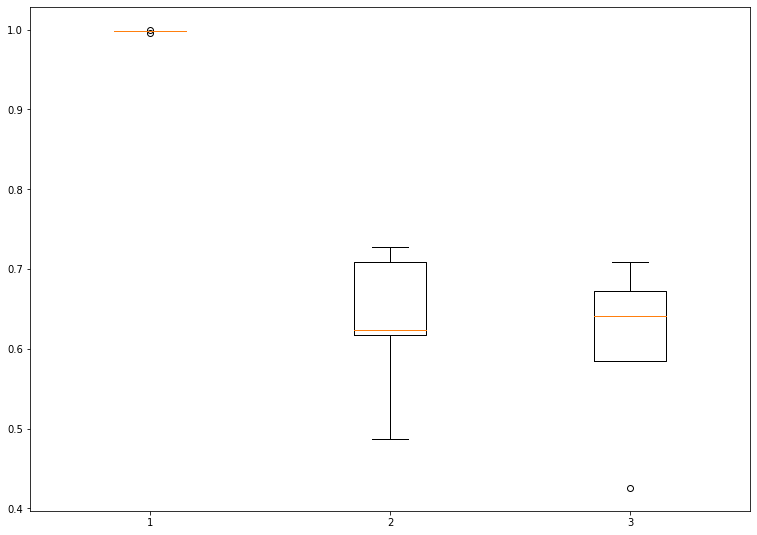

In [80]:
#BoxPlot for cross validation scores

data_SVC = [cvs_SVC_lda, cvs_SVC_pca, cvs_SVC_normal]

fig_SVC = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax_SVC = fig_SVC.add_axes([0, 0, 1, 1])
  
# Creating plot
bp_SVC = ax_SVC.boxplot(data_SVC)
  
# show plot
plt.show()

## MLP

In [81]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

def trainMLP(train_data, label_data, test_data,test_label):
  clf = MLPClassifier()
  clf=clf.fit(train_data,label_data)
  print(clf.score(test_data,test_label))
  cvs = cross_val_score(clf, train_data, label_data, cv=5)
  print(cvs)
  
  predicted_test = clf.predict(test_data)
  return predicted_test,cvs

## MLP_LDA

In [82]:
predicted_test_MLP_lda,cvs_MLP_lda=trainMLP(lda_train_data,label_data,lda_test_data,test_label)
predicted_test_MLP_lda

0.4805290227773696
[0.99637681 0.99818841 0.99818841 0.99818841 1.        ]


array([1, 0, 1, ..., 0, 0, 0])

In [83]:
pred_MLP_lda=predictDeepFakeResult(predicted_test_MLP_lda,frame_count_test_fake+frame_count_test_real)
print(pred_MLP_lda)

[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


In [84]:

accuracy_score(actual_test_label, pred_MLP_lda)

0.48

In [123]:

f1_score(actual_test_label, pred_MLP_lda)

0.5806451612903226

In [86]:

log_loss(actual_test_label,pred_MLP_lda)

17.960467572377027

## MLP_PCA

In [87]:
predicted_test_MLP_pca,cvs_MLP_pca=trainMLP(pca_train_data,label_data,pca_test_data,test_label)
predicted_test_MLP_pca

0.5870683321087435
[0.38586957 0.60326087 0.64673913 0.53623188 0.69384058]


array([1, 1, 1, ..., 0, 0, 0])

In [88]:
pred_MLP_pca=predictDeepFakeResult(predicted_test_MLP_pca,frame_count_test_fake+frame_count_test_real)
print(pred_MLP_pca)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [89]:

accuracy_score(actual_test_label, pred_MLP_pca)

0.7

In [90]:

f1_score(actual_test_label, pred_MLP_pca)

0.7619047619047619

In [91]:

log_loss(actual_test_label,pred_MLP_pca)

10.361856805753659

In [92]:
predicted_test_MLP_pca_noise,_=trainMLP(pca_train_data_noise,label_data_noise,pca_test_data,test_label)
predicted_test_MLP_pca_noise

0.56208670095518
[0.38768116 0.54710145 0.5942029  0.54528986 0.67572464]


array([1, 1, 1, ..., 1, 1, 1])

In [93]:
pred_MLP_pca_noise=predictDeepFakeResult(predicted_test_MLP_pca_noise,frame_count_test_fake+frame_count_test_real)
print(pred_MLP_pca_noise)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


In [94]:

accuracy_score(actual_test_label, pred_MLP_pca_noise)

0.64

In [95]:

f1_score(actual_test_label, pred_MLP_pca_noise)

0.7096774193548386

In [96]:

log_loss(actual_test_label,pred_MLP_pca_noise)

12.434199381396905

##MLP_Normal

In [97]:
predicted_test_MLP_normal,cvs_MLP_normal=trainMLP(train_data,label_data,test_data,test_label)
predicted_test_MLP_normal

0.544452608376194
[0.35144928 0.51449275 0.51630435 0.48369565 0.48188406]


array([1, 1, 1, ..., 1, 1, 0])

In [98]:
pred_MLP_normal=predictDeepFakeResult(predicted_test_MLP_normal,frame_count_test_fake+frame_count_test_real)
print(pred_MLP_normal)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [99]:

accuracy_score(actual_test_label, pred_MLP_normal)

0.6

In [100]:

f1_score(actual_test_label, pred_MLP_normal)

0.7142857142857143

In [101]:

log_loss(actual_test_label,pred_MLP_normal)

13.815830396936354

##Comaprison

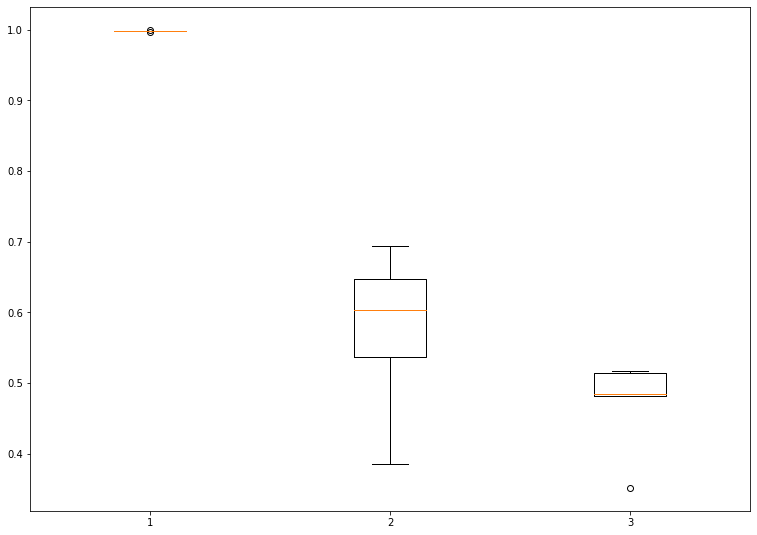

In [102]:
#BoxPlot for cross validation scores

data_MLP = [cvs_MLP_lda, cvs_MLP_pca, cvs_MLP_normal]

fig_MLP = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax_MLP = fig_MLP.add_axes([0, 0, 1, 1])
  
# Creating plot
bp_MLP = ax_MLP.boxplot(data_MLP)
  
# show plot
plt.show()

## KNN

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
def trainKNN(train_data, label_data, test_data,test_label):
  clf = KNeighborsClassifier(n_neighbors=3)
  clf.fit(train_data,label_data)
  print(clf.score(test_data,test_label))
  cvs = cross_val_score(clf, train_data, label_data, cv=5)
  print(cvs)
  
  predicted_test = clf.predict(test_data)
  return predicted_test,cvs

## KNN_LDA

In [104]:
predicted_test_KNN_lda,cvs_KNN_lda=trainKNN(lda_train_data,label_data,lda_test_data,test_label)
predicted_test_KNN_lda

0.48126377663482733
[0.99456522 0.99818841 0.99818841 0.99818841 1.        ]


array([1, 0, 1, ..., 0, 0, 0])

In [105]:
pred_KNN_lda=predictDeepFakeResult(predicted_test_KNN_lda,frame_count_test_fake+frame_count_test_real)
print(pred_KNN_lda)

[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]


In [106]:

accuracy_score(actual_test_label, pred_KNN_lda)

0.44

In [107]:

f1_score(actual_test_label, pred_KNN_lda)

0.5625

In [108]:

log_loss(actual_test_label,pred_KNN_lda)

19.342050612070665

## KNN_PCA

In [109]:
predicted_test_KNN_pca,cvs_KNN_pca=trainKNN(pca_train_data,label_data,pca_test_data,test_label)
predicted_test_KNN_pca

0.5980896399706098
[0.35144928 0.59057971 0.63949275 0.57246377 0.80434783]


array([1, 1, 1, ..., 0, 0, 0])

In [110]:
pred_KNN_pca=predictDeepFakeResult(predicted_test_KNN_pca,frame_count_test_fake+frame_count_test_real)
print(pred_KNN_pca)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [111]:

accuracy_score(actual_test_label, pred_KNN_pca)

0.66

In [112]:

f1_score(actual_test_label, pred_KNN_pca)

0.711864406779661

In [113]:

log_loss(actual_test_label,pred_KNN_pca)

11.743391869601483

##KNN_Normal

In [114]:
predicted_test_KNN_normal,cvs_KNN_normal=trainKNN(train_data,label_data,test_data,test_label)
predicted_test_KNN_normal

0.6311535635562087
[0.28985507 0.5942029  0.63043478 0.5923913  0.77355072]


array([1, 1, 0, ..., 0, 0, 0])

In [115]:
pred_KNN_normal=predictDeepFakeResult(predicted_test_KNN_normal,frame_count_test_fake+frame_count_test_real)
print(pred_KNN_normal)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [116]:
from sklearn.metrics import accuracy_score
accuracy_score(actual_test_label, pred_KNN_normal)

0.68

In [117]:
from sklearn.metrics import f1_score
f1_score(actual_test_label, pred_KNN_normal)

0.7241379310344828

In [118]:
from sklearn.metrics import log_loss
log_loss(actual_test_label,pred_KNN_normal)

11.052600349754666

##Comaprison

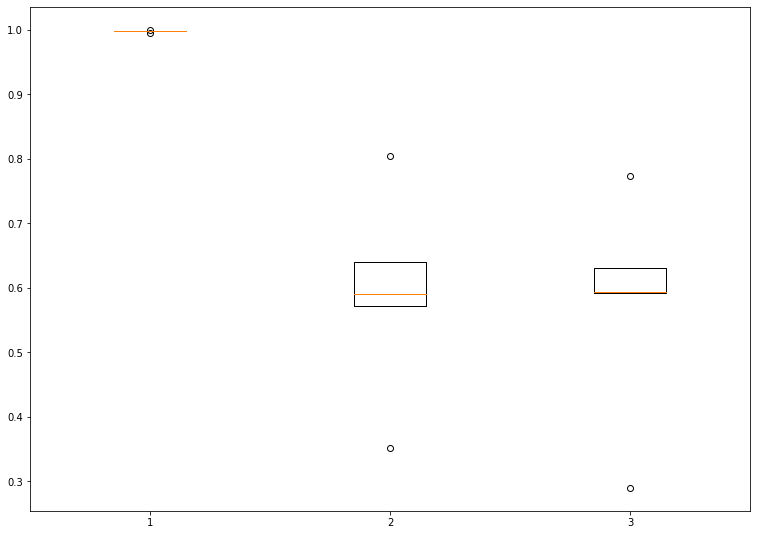

In [119]:
#BoxPlot for cross validation scores

data_KNN = [cvs_KNN_lda, cvs_KNN_pca, cvs_KNN_normal]

fig_KNN = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax_KNN = fig_KNN.add_axes([0, 0, 1, 1])
  
# Creating plot
bp_KNN = ax_KNN.boxplot(data_KNN)
  
# show plot
plt.show()

##Comaprison for LDAs

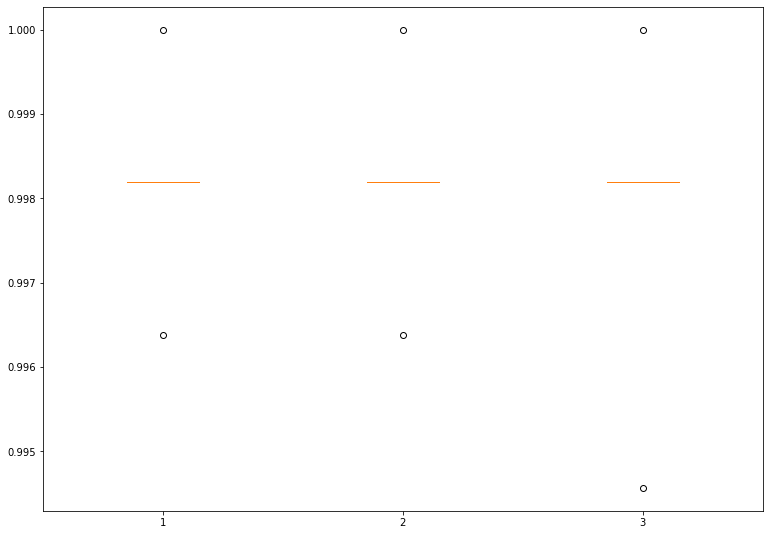

In [120]:
#BoxPlot for cross validation scores

data_LDA = [cvs_SVC_lda, cvs_MLP_lda, cvs_KNN_lda]

fig_LDA = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax_LDA = fig_LDA.add_axes([0, 0, 1, 1])
  
# Creating plot
bp_LDA = ax_LDA.boxplot(data_LDA)
  
# show plot
plt.show()

##Comparison for PCAs

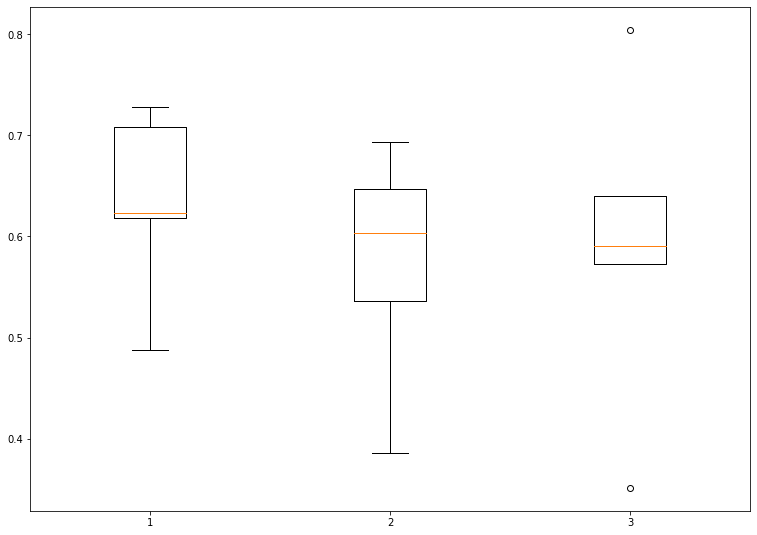

In [121]:
#BoxPlot for cross validation scores

data_PCA = [cvs_SVC_pca, cvs_MLP_pca, cvs_KNN_pca]

fig_PCA = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax_PCA = fig_PCA.add_axes([0, 0, 1, 1])
  
# Creating plot
bp_PCA = ax_PCA.boxplot(data_PCA)
  
# show plot
plt.show()

##Comparison for Normals 

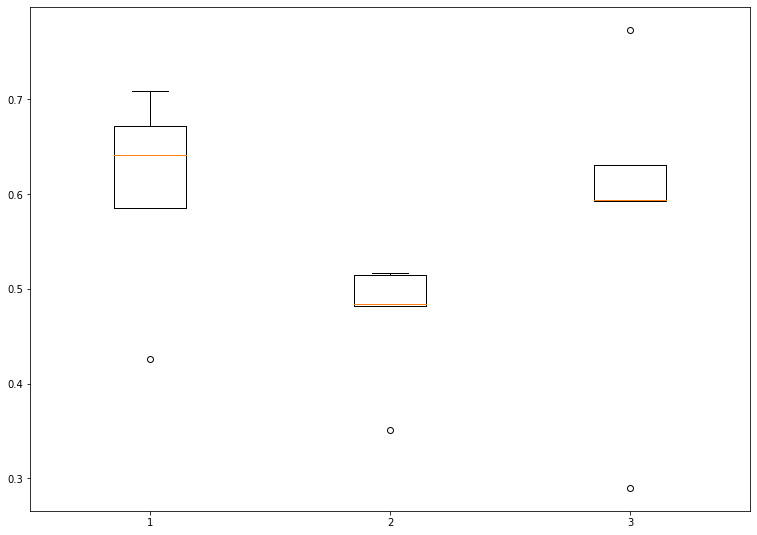

In [122]:
#BoxPlot for cross validation scores

data_NORMAL = [cvs_SVC_normal, cvs_MLP_normal, cvs_KNN_normal]

fig_NORMAL = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax_NORMAL = fig_NORMAL.add_axes([0, 0, 1, 1])
  
# Creating plot
bp_NORMAL = ax_NORMAL.boxplot(data_NORMAL)
  
# show plot
plt.show()

##InceptionResnetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
def resizingImages(img_list):
  newImgList=[]
  for i in img_list:
    img = cv2.resize(i,(128, 128), interpolation=cv2.INTER_CUBIC)
    newImgList.append(img)
  return np.array(newImgList)

In [ ]:
train_Resizedimages_mediapipe_label = [0]*len(processedImagePath_Train_Fake_mediapipe) + [1]*len(processedImagePath_Train_Real_mediapipe)
train_Resizedimages_mediapipe_label = to_categorical(train_Resizedimages_mediapipe_label,2)
val_Resizedimages_mediapipe_label = [0]*len(processedImagePath_Val_Fake_mediapipe) + [1]*len(processedImagePath_Val_Real_mediapipe)
val_Resizedimages_mediapipe_label = to_categorical(val_Resizedimages_mediapipe_label,2)
test_Resizedimages_mediapipe_label = [0]*len(processedImagePath_Test_Fake_mediapipe) + [1]*len(processedImagePath_Test_Real_mediapipe)
test_Resizedimages_mediapipe_label = to_categorical(test_Resizedimages_mediapipe_label,2)
# train_images_mediapipe_label_CNN = [[1,0] for i in range(len(processedImagePath_Train_Fake_mediapipe))] + [[0,1] for i in range(len(processedImagePath_Train_Real_mediapipe))]
# val_images_mediapipe_label_CNN = [[1,0] for i in range(len(processedImagePath_Val_Fake_mediapipe))] + [[0,1] for i in range(len(processedImagePath_Val_Real_mediapipe))]
# print(train_images_mediapipe_label_CNN)

In [ ]:
train_Resizedimages_mediapipe_label_noise = [0]*len(processedImagePath_Train_Fake_mediapipe_noise) + [1]*len(processedImagePath_Train_Real_mediapipe_noise)
train_Resizedimages_mediapipe_label_noise = to_categorical(train_Resizedimages_mediapipe_label_noise,2)

In [ ]:
print(train_Resizedimages_mediapipe_label)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
def createImageArray(path_list):
  img_list = []
  for path in path_list:
    img = cv2.imread(path)
    img_list.append(img)
  return img_list

In [ ]:
train_images_mediapipe_CNN = createImageArray(processedImagePath_Train_Fake_mediapipe + processedImagePath_Train_Real_mediapipe)

In [ ]:
train_images_mediapipe_CNN_noise = createImageArray(processedImagePath_Train_Fake_mediapipe_noise + processedImagePath_Train_Real_mediapipe_noise)

In [ ]:
val_images_mediapipe_CNN = createImageArray(processedImagePath_Val_Fake_mediapipe + processedImagePath_Val_Real_mediapipe)

In [ ]:
test_images_mediapipe_CNN = createImageArray(processedImagePath_Test_Fake_mediapipe + processedImagePath_Test_Real_mediapipe)

In [ ]:
print(val_images_mediapipe_CNN)

In [ ]:
train_Resizedimages_mediapipe = resizingImages(train_images_mediapipe_CNN)
# train_Resizedimages_mediapipe_label = np.array(train_images_mediapipe_label_CNN)
val_Resizedimages_mediapipe = resizingImages(val_images_mediapipe_CNN)
# val_Resizedimages_mediapipe_label = np.array(val_images_mediapipe_label_CNN )

In [ ]:
train_Resizedimages_mediapipe_noise = resizingImages(train_images_mediapipe_CNN_noise)

In [ ]:
# test_images_mediapipe_label_CNN = [[1,0] for i in range(len(processedImagePath_Test_Fake_mediapipe))] + [[0,1] for i in range(len(processedImagePath_Test_Real_mediapipe))]
test_Resizedimages_mediapipe = resizingImages(test_images_mediapipe_CNN)
# test_Resizedimages_mediapipe_label  = np.array(test_images_mediapipe_label_CNN )

In [ ]:
train_Resizedimages_mediapipe = train_Resizedimages_mediapipe.astype('float32')
val_Resizedimages_mediapipe = val_Resizedimages_mediapipe.astype('float32')
train_Resizedimages_mediapipe  = train_Resizedimages_mediapipe  / 255.
val_Resizedimages_mediapipe = val_Resizedimages_mediapipe / 255.

In [ ]:
train_Resizedimages_mediapipe_noise = train_Resizedimages_mediapipe_noise.astype('float32')
train_Resizedimages_mediapipe_noise = train_Resizedimages_mediapipe_noise / 255

In [ ]:
test_Resizedimages_mediapipe = test_Resizedimages_mediapipe.astype('float32')
test_Resizedimages_mediapipe = test_Resizedimages_mediapipe / 255

In [ ]:
googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
EPOCHS = 20
BATCH_SIZE = 50

history = model.fit(train_Resizedimages_mediapipe, train_Resizedimages_mediapipe_label, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (val_Resizedimages_mediapipe, val_Resizedimages_mediapipe_label), verbose = 1)

Epoch 1/20
28/28 [==============================] - 51s 431ms/step - loss: 0.7498 - accuracy: 0.5323 - val_loss: 1.2229 - val_accuracy: 0.4813
Epoch 2/20
28/28 [==============================] - 7s 236ms/step - loss: 0.6457 - accuracy: 0.5711 - val_loss: 0.9957 - val_accuracy: 0.4899
Epoch 3/20
28/28 [==============================] - 7s 236ms/step - loss: 0.5619 - accuracy: 0.6864 - val_loss: 0.9141 - val_accuracy: 0.4784
Epoch 4/20
28/28 [==============================] - 7s 235ms/step - loss: 0.5020 - accuracy: 0.7626 - val_loss: 0.8391 - val_accuracy: 0.4640
Epoch 5/20
28/28 [==============================] - 7s 236ms/step - loss: 0.4308 - accuracy: 0.8372 - val_loss: 0.8070 - val_accuracy: 0.4697
Epoch 6/20
28/28 [==============================] - 7s 236ms/step - loss: 0.3403 - accuracy: 0.9209 - val_loss: 0.8167 - val_accuracy: 0.4971
Epoch 7/20
28/28 [==============================] - 7s 236ms/step - loss: 0.2455 - accuracy: 0.9509 - val_loss: 0.8263 - val_accuracy: 0.5331
Epoch

In [ ]:
predicted_test_Inception= model.predict_classes(test_Resizedimages_mediapipe)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(predicted_test_Inception)

[1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1
 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0
 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1
 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1
 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 1 0 

In [ ]:
a=0
b=0
for i in predicted_test_Inception:
  if i==0:
    a+=1
  else:
    b+=1
print(a,b)

219 491


In [ ]:
def predictDeepFakeResultInception(predicted_test,frame_count_test):
  k=0
  prediction=[]
  len1=len(predicted_test)
  for i in frame_count_test:
    real_count=0
    fake_count=0
    # if i+k>=len1:
    #   break
    for j in range(i):
      if predicted_test[k]>0.5:
        real_count+=1
      else:
        fake_count+=1
      k+=1
    if real_count/(real_count+fake_count)>=0.5:
      prediction.append(1)
    else:
      prediction.append(0)
  return prediction

In [ ]:
pred_Inception_mediapipe = predictDeepFakeResultInception(predicted_test_Inception,frame_count_test_fake+frame_count_test_real)
print(pred_Inception_mediapipe)

[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(actual_test_label, pred_Inception_mediapipe)

0.5

In [ ]:
from sklearn.metrics import f1_score
f1_score(actual_test_label, pred_Inception_mediapipe)

0.625

In [ ]:
from sklearn.metrics import log_loss
log_loss(actual_test_label, pred_Inception_mediapipe)

17.269721363051257

## CNN

In [ ]:
def createImageArray(path_list):
  img_list = []
  for path in path_list:
    img = cv2.imread(path)
    img_list.append(img)
  return img_list

In [ ]:
train_images_mediapipe_CNN = createImageArray(processedImagePath_Train_Fake_mediapipe + processedImagePath_Train_Real_mediapipe)

In [ ]:
train_images_mediapipe_label_CNN = [0]*len(processedImagePath_Train_Fake_mediapipe) + [1]*len(processedImagePath_Train_Real_mediapipe)

In [ ]:
val_images_mediapipe_CNN = createImageArray(processedImagePath_Val_Fake_mediapipe + processedImagePath_Val_Real_mediapipe)

In [ ]:
val_images_mediapipe_label_CNN = [0]*len(processedImagePath_Val_Fake_mediapipe) + [1]*len(processedImagePath_Val_Real_mediapipe)

In [ ]:
test_images_mediapipe_CNN = createImageArray(processedImagePath_Test_Fake_mediapipe + processedImagePath_Test_Real_mediapipe)

In [ ]:
test_images_mediapipe_label_CNN = [0]*len(processedImagePath_Test_Fake_mediapipe) + [1]*len(processedImagePath_Test_Real_mediapipe)

In [ ]:
train_images_mediapipe_CNN = np.array(train_images_mediapipe_CNN)
train_images_mediapipe_label_CNN = np.array(train_images_mediapipe_label_CNN)
val_images_mediapipe_CNN = np.array(val_images_mediapipe_CNN)
val_images_mediapipe_label_CNN  = np.array(val_images_mediapipe_label_CNN )
test_images_mediapipe_CNN = np.array(test_images_mediapipe_CNN)
test_images_mediapipe_label_CNN  = np.array(test_images_mediapipe_label_CNN )

In [ ]:
train_images_mediapipe_CNN = train_images_mediapipe_CNN.astype('float32')
val_images_mediapipe_CNN = val_images_mediapipe_CNN.astype('float32')
train_images_mediapipe_CNN  = train_images_mediapipe_CNN  / 255
val_images_mediapipe_CNN = val_images_mediapipe_CNN / 255
test_images_mediapipe_CNN = test_images_mediapipe_CNN.astype('float32')
test_images_mediapipe_CNN  = test_images_mediapipe_CNN  / 255

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
batch_size = 32
epochs = 10
num_classes = 2

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# custom_callbacks = [
#     EarlyStopping(
#         monitor = 'val_loss',
#         mode = 'min',
#         patience = 5,
#         verbose = 1
#     ),
#     ModelCheckpoint(
#         filepath = os.path.join(checkpoint_filepath, 'best_model.h5'),
#         monitor = 'val_loss',
#         mode = 'min',
#         verbose = 1,
#         save_best_only = True
#     )
# ]

In [ ]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
classifier.add(MaxPooling2D((2, 2),padding='same'))
classifier.add(Dropout(0.25))

classifier.add(LeakyReLU(alpha=0.1)) 
classifier.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
classifier.add(Dropout(0.4))

 
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
# classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
!pip install efficientnet

     |████████████████████████████████| 51kB 3.0MB/s 


In [ ]:
from efficientnet.tfkeras import EfficientNetB0 
from keras.regularizers import l2
efficient_net = EfficientNetB0(
    weights = 'imagenet',
    input_shape = (128, 128, 3),
    include_top = False,
    pooling = 'max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 1280)              4049564   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 4,771,229
Trainable params: 4,729,213
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
# cnn.summary()
# classifier.summary()
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
x = []
for i in range(len(train_Resizedimages_mediapipe_label)):
  if(train_Resizedimages_mediapipe_label[i][0]==1):
    x.append(0)
  else:
    x.append(1)

In [ ]:
y = []
for i in range(len(val_Resizedimages_mediapipe_label)):
  if(val_Resizedimages_mediapipe_label[i][0]==1):
    y.append(0)
  else:
    y.append(1)

In [ ]:
# train_cnn = cnn.fit(train_images_dlib_CNN, train_images_dlib_label_CNN, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(val_images_dlib_CNN, val_images_dlib_label_CNN))
train_cnn = model.fit(train_Resizedimages_mediapipe, np.array(x),epochs=epochs,verbose=1,validation_data=(val_Resizedimages_mediapipe, np.array(y)),validation_steps = 100 )

Epoch 1/10
43/43 [==============================] - 19s 175ms/step - loss: 1.1261 - accuracy: 0.5739 - val_loss: 0.8243 - val_accuracy: 0.5288
Epoch 2/10
43/43 [==============================] - 5s 124ms/step - loss: 0.5410 - accuracy: 0.7572 - val_loss: 0.7729 - val_accuracy: 0.4784
Epoch 3/10
43/43 [==============================] - 5s 124ms/step - loss: 0.4040 - accuracy: 0.8291 - val_loss: 0.7277 - val_accuracy: 0.5562
Epoch 4/10
43/43 [==============================] - 5s 124ms/step - loss: 0.2529 - accuracy: 0.9143 - val_loss: 0.8103 - val_accuracy: 0.4942
Epoch 5/10
43/43 [==============================] - 5s 123ms/step - loss: 0.1995 - accuracy: 0.9340 - val_loss: 1.0552 - val_accuracy: 0.4755
Epoch 6/10
43/43 [==============================] - 5s 124ms/step - loss: 0.1507 - accuracy: 0.9488 - val_loss: 0.9652 - val_accuracy: 0.4798
Epoch 7/10
43/43 [==============================] - 5s 122ms/step - loss: 0.1052 - accuracy: 0.9731 - val_loss: 0.8730 - val_accuracy: 0.5504
Epoch

In [ ]:
predicted_test_CNN= model.predict(test_Resizedimages_mediapipe)

In [ ]:
pred_CNN_mediapipe = predictDeepFakeResult(predicted_test_CNN,frame_count_test_fake+frame_count_test_real)

In [ ]:
# print(pred_CNN_mediapipe)
print(predicted_test_CNN)

[[0.28155768]
 [0.6948064 ]
 [0.39760694]
 [0.79739827]
 [0.6812311 ]
 [0.9948106 ]
 [0.9431735 ]
 [0.3242211 ]
 [0.7195892 ]
 [0.93920153]
 [0.96899456]
 [0.99642485]
 [0.7162836 ]
 [0.60087425]
 [0.8414929 ]
 [0.97562444]
 [0.85236967]
 [0.96930456]
 [0.04793001]
 [0.06607293]
 [0.9479438 ]
 [0.21724644]
 [0.9835759 ]
 [0.67222536]
 [0.33976325]
 [0.9542685 ]
 [0.18251415]
 [0.79807365]
 [0.94920987]
 [0.48270568]
 [0.1273234 ]
 [0.50298697]
 [0.08473337]
 [0.05995884]
 [0.6738778 ]
 [0.49868685]
 [0.2820519 ]
 [0.22858603]
 [0.94929063]
 [0.9383186 ]
 [0.67663676]
 [0.55024457]
 [0.8691383 ]
 [0.23441783]
 [0.40709716]
 [0.246676  ]
 [0.8810549 ]
 [0.47104967]
 [0.03832456]
 [0.5810825 ]
 [0.7376904 ]
 [0.11843096]
 [0.4384005 ]
 [0.34028643]
 [0.5513672 ]
 [0.11495265]
 [0.92962635]
 [0.27739498]
 [0.719011  ]
 [0.5791005 ]
 [0.10065175]
 [0.6429342 ]
 [0.8729266 ]
 [0.10934336]
 [0.931618  ]
 [0.899885  ]
 [0.5142151 ]
 [0.7419824 ]
 [0.9923878 ]
 [0.5159224 ]
 [0.9036514 ]
 [0.53

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(actual_test_label, pred_CNN_mediapipe)

0.5

In [ ]:
from sklearn.metrics import f1_score
f1_score(actual_test_label, pred_CNN_mediapipe)

0.0

In [ ]:
from sklearn.metrics import log_loss
log_loss(actual_test_label, pred_CNN_mediapipe)

17.269388197455342